# Prepare

In [1]:
# !pip install -U gdown

In [2]:
# donwload word2vec
import gdown
url = 'https://drive.google.com/u/0/uc?export=download&confirm=xJKk&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)
!gzip -d '/content/GoogleNews-vectors-negative300.bin.gz'

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=xJKk&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:23, 68.8MB/s]


In [3]:
# test.txt, train.txt, valid.txt made at ch6
!ls '/content/'

GoogleNews-vectors-negative300.bin  sample_data  test.txt  train.txt  valid.txt


In [4]:
import pandas as pd
train_df = pd.read_csv('train.txt', delimiter='\t')
valid_df = pd.read_csv('valid.txt', delimiter='\t')
test_df = pd.read_csv('test.txt', delimiter='\t')

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [6]:
import re
import time
from pathlib import Path

import numpy as np
import gensim
import pickle
import scipy

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# 70

特徴量ベクトルとラベルの保存
- b = business, t = science and technology, e = entertainment, m = health

In [7]:
category_map = {'b': 0, 't': 1, 'e':2, 'm': 3}
train_df['category'] = train_df['category'].map(category_map)
valid_df['category'] = valid_df['category'].map(category_map)
test_df['category'] = test_df['category'].map(category_map)

In [8]:
# 第6章と同様に前処理
# ulrの削除
def remove_url(text):
    url_pat = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pat, ' ', text)
    return text

# 小文字化
def lower_text(text):
    return text.lower()

# トークン化
def tokenize(text):
    tokens = ' '.join([str(token) for token in nlp.make_doc(text) if str(token) != ' '])
    return tokens

def preporcessing(text):
    text = lower_text(text)
    text = remove_url(text)
    tokens = tokenize(text)
    return tokens

In [9]:
train_title_tokenized = train_df['title'].map(preporcessing)
valid_title_tokenized = valid_df['title'].map(preporcessing)
test_title_tokenized = test_df['title'].map(preporcessing)

In [10]:
# embeddingのロード
model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [14]:
# inputするベクトルはtitleの単語ベクトルの平均
def get_avg_vector(text):
    vecs = []
    tokens = text.strip().split()
    for token in tokens:
        if model.vocab.get(token):
            vecs.append(model.get_vector(token))

    if vecs == []:
        raise ValueError

    return np.vstack(vecs).mean(axis=0)

In [15]:
x_train = np.array(train_title_tokenized.map(get_avg_vector).to_list())
y_train = train_df['category'].values

x_valid = np.array(valid_title_tokenized.map(get_avg_vector).to_list())
y_valid = valid_df['category'].values

x_test = np.array(test_title_tokenized.map(get_avg_vector).to_list())
y_test = test_df['category'].values

In [16]:
with open('train.pkl', 'wb') as f:
    pickle.dump((x_train, y_train), f)

with open('valid.pkl', 'wb') as f:
    pickle.dump((x_valid, y_valid), f)

with open('test.pkl', 'wb') as f:
    pickle.dump((x_test, y_test), f)

# 71 - 72
単層NNによる予測
- 出力値の確認
- 損失と勾配の計算

In [17]:
with open('train.pkl', 'rb') as f:
    x_train, y_train = pickle.load(f)

with open('valid.pkl', 'rb') as f:
    x_valid, y_valid = pickle.load(f)

with open('test.pkl', 'rb') as f:
    x_test, y_test = pickle.load(f)

In [18]:
# LogisticRegressionでの参考値
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train, y_train)
valid_preds = clf.predict(x_valid)
print(accuracy_score(y_valid, valid_preds))

0.9098621420996819


In [19]:
# tensort化
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_valid = torch.tensor(x_valid)
y_valid = torch.tensor(y_valid)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

In [20]:
class SingleLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(300, 5, bias=False)
    
    def forward(self, x):
        return self.fc(x)

In [21]:
model = SingleLayerPerceptron()

In [22]:
with torch.no_grad():
    y_hat = model(x_train[0])
torch.softmax(y_hat, dim=-1)

tensor([0.2014, 0.1981, 0.1980, 0.1981, 0.2044])

In [23]:
with torch.no_grad():
    y_hat = model(x_train[0:4])
torch.softmax(y_hat, dim=-1)

tensor([[0.2014, 0.1981, 0.1980, 0.1981, 0.2044],
        [0.1987, 0.2024, 0.2018, 0.1968, 0.2002],
        [0.2026, 0.2009, 0.1968, 0.2025, 0.1972],
        [0.1930, 0.2104, 0.1933, 0.2043, 0.1990]])

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
model.zero_grad()

In [26]:
y_hat = model(x_train[:1])

In [27]:
loss = criterion(y_hat, y_train[:1])

In [28]:
loss.backward()

In [29]:
print('loss:',loss.item())
print('grad:\n',model.fc.weight.grad)

loss: 1.619483232498169
grad:
 tensor([[-0.0184,  0.0183,  0.0020,  ..., -0.0115, -0.0083,  0.0275],
        [-0.0181,  0.0180,  0.0020,  ..., -0.0114, -0.0082,  0.0271],
        [ 0.0732, -0.0728, -0.0080,  ...,  0.0460,  0.0332, -0.1096],
        [-0.0181,  0.0180,  0.0020,  ..., -0.0114, -0.0082,  0.0271],
        [-0.0187,  0.0186,  0.0020,  ..., -0.0117, -0.0085,  0.0279]])


In [30]:
model.zero_grad()
y_hat = model(x_train[0:4])
loss = criterion(y_hat, y_train[0:4])
loss.backward()

In [31]:
print('loss:',loss.item())
print('grad:\n',model.fc.weight.grad)

loss: 1.6149988174438477
grad:
 tensor([[-0.0125,  0.0030, -0.0010,  ..., -0.0053,  0.0119,  0.0073],
        [ 0.0054,  0.0095, -0.0004,  ..., -0.0070, -0.0025,  0.0039],
        [-0.0034, -0.0315,  0.0021,  ...,  0.0262, -0.0042, -0.0194],
        [ 0.0053,  0.0094, -0.0003,  ..., -0.0069, -0.0026,  0.0040],
        [ 0.0051,  0.0096, -0.0004,  ..., -0.0069, -0.0026,  0.0043]])


# 73-76
- 100エポックでランダムに初期化した行列を最適化して、検証データの正解率を確認する 。各エポックでのlossと正解率を計算する
- エポックの毎の重み行列とオプティマイザの状態を保存する

In [32]:
save_dir = Path('./checkpoint')
save_dir.mkdir(exist_ok=True)

In [33]:
def evaluate_accuracy(model, y, x):
    with torch.no_grad():
        y_hat = model(x)
    return accuracy_score(y.numpy(), torch.argmax(y_hat, axis=-1).numpy())

def evaluate_loss(model, criterion, y, x):
    with torch.no_grad():
        y_hat = model(x)
        return float(criterion(y_hat, y).numpy())

In [34]:
model = SingleLayerPerceptron()

acc_epcohs = []
losses_epochs = []

model.zero_grad()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

losses = []
with tqdm(range(300)) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()

        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()

        # save
        torch.save(optimizer.state_dict(), save_dir/f'epoch_{epoch}_optimizer.pth')
        torch.save(model.state_dict(), save_dir/f'epoch_{epoch}_model.pth')

        acc_score = {}
        acc_score['train_acc'] = evaluate_accuracy(model, y_train, x_train)
        acc_score['valid_acc'] = evaluate_accuracy(model, y_valid, x_valid)
        acc_score['test_acc'] = evaluate_accuracy(model, y_test, x_test)
        acc_epcohs.append(acc_score)
        
        losses = {}
        losses['train_loss'] = evaluate_loss(model, criterion, y_train, x_train)
        losses['valid_loss'] = evaluate_loss(model, criterion, y_valid, x_valid)
        losses['test_loss'] = evaluate_loss(model, criterion, y_test, x_test)
        losses_epochs.append(losses)

        pbar.set_postfix(acc_score)

In [35]:
acc_df = pd.DataFrame(acc_epcohs)
loss_df = pd.DataFrame(losses_epochs)

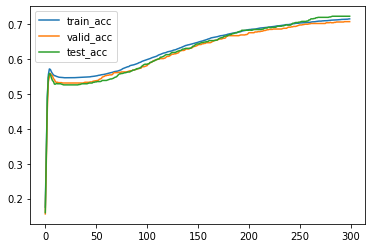

In [36]:
acc_df.plot()

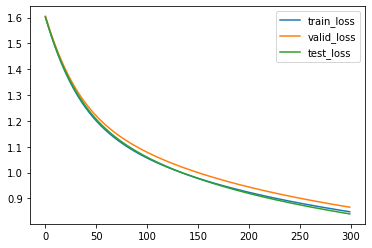

In [37]:
loss_df.plot()

# 77 ミニバッチ化
バッチ化して処理時間の遷移を比較する

In [38]:
class Trainer:
    def __init__(self, model, batch_size, num_epoch):
        self.trn_ds = TensorDataset(x_train, y_train)
        self.trn_dl = DataLoader(self.trn_ds, batch_size=batch_size)

        self.val_ds = TensorDataset(x_valid, y_valid)
        self.val_dl = DataLoader(self.val_ds, batch_size=batch_size)

        self.test_ds = TensorDataset(x_test, y_test)
        self.test_dl = DataLoader(self.test_ds, batch_size=batch_size)

        self.model = model
        self.num_epoch = num_epoch
        self.optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
        self.criterion = nn.CrossEntropyLoss()

    def batch_step(self):
        for xs, ys in self.trn_dl:
            self.optimizer.zero_grad()
            
            y_hat = self.model(xs)
            loss = self.criterion(y_hat, ys)
            loss.backward()
            self.optimizer.step()

    def evaluation(self, dl):
        acc_scores = []
        losses = []
        model.eval()
        with torch.no_grad():
            for xs, ys in dl:
                acc = evaluate_accuracy(self.model, ys, xs)
                loss = evaluate_loss(self.model, self.criterion, ys, xs)
                acc_scores.append(acc)
                losses.append(loss)

        return np.mean(acc_scores), np.mean(losses)

    def train(self):
        self.model.zero_grad()

        acc_epcohs = []
        losses_epochs = []
        epoch_time = []

        with tqdm(range(self.num_epoch)) as pbar:
            for epoch in pbar:
                now = time.time()
                self.batch_step()
                elasped = time.time() - now
                epoch_time.append(elasped)
            
                # 評価
                acc_score = {}
                losses = {}

                acc_epoch, loss_epoch = self.evaluation(self.trn_dl)
                acc_score['train_acc'] = acc_epoch
                losses['train_loss'] = loss_epoch

                acc_epoch, loss_epoch = self.evaluation(self.val_dl)
                acc_score['valid_acc'] = acc_epoch
                losses['valid_loss'] = loss_epoch

                acc_epoch, loss_epoch = self.evaluation(self.test_dl)
                acc_score['test_acc'] = acc_epoch
                losses['test_loss'] = loss_epoch


                acc_epcohs.append(acc_score)
                losses_epochs.append(losses)
                pbar.set_postfix(acc_score)

        return acc_epcohs, losses_epochs, np.mean(epoch_time)

In [39]:
print(pd.DataFrame(acc_epcohs).mean())

train_acc    0.633853
valid_acc    0.623468
test_acc     0.627252
dtype: float64


In [40]:
batch_epoch_time = {}
for batch_size in [1, 2, 4, 8]:
    model = SingleLayerPerceptron()
    trainer = Trainer(model, batch_size, 10)

    now = time.time()
    acc_epcohs, losses_epochs, epoch_time = trainer.train()
    print(f'batch_size: {batch_size}, epoch mean time: {epoch_time} s')
    print(pd.DataFrame(acc_epcohs).mean())


batch_size: 1, epoch mean time: 1.7310770273208618 s
train_acc    0.896623
valid_acc    0.904772
test_acc     0.883915
dtype: float64



batch_size: 2, epoch mean time: 0.9308552265167236 s
train_acc    0.886530
valid_acc    0.899894
test_acc     0.881501
dtype: float64



batch_size: 4, epoch mean time: 0.500223183631897 s
train_acc    0.872564
valid_acc    0.883263
test_acc     0.876371
dtype: float64



batch_size: 8, epoch mean time: 0.3083126783370972 s
train_acc    0.851536
valid_acc    0.861093
test_acc     0.860294
dtype: float64


# 78-79
多層ニューラルネットに変更してgpuで実行

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [70]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc3 = nn.Linear(50, 5)

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [71]:
def evaluate_accuracy(model, y, x):
    with torch.no_grad():
        y_hat = model(x)
        if device == 'cuda':
            return accuracy_score(y.cpu().numpy(), torch.argmax(y_hat, axis=-1).cpu().numpy())
        else:
            return accuracy_score(y.numpy(), torch.argmax(y_hat, axis=-1).numpy())

def evaluate_loss(model, criterion, y, x):
    with torch.no_grad():
        y_hat = model(x)
        return criterion(y_hat, y).item()

In [72]:
class Trainer:
    def __init__(self, model, batch_size, num_epoch):
        self.trn_ds = TensorDataset(x_train, y_train)
        self.trn_dl = DataLoader(self.trn_ds, batch_size=batch_size)

        self.val_ds = TensorDataset(x_valid, y_valid)
        self.val_dl = DataLoader(self.val_ds, batch_size=batch_size)

        self.test_ds = TensorDataset(x_test, y_test)
        self.test_dl = DataLoader(self.test_ds, batch_size=batch_size)

        self.model = model
        self.num_epoch = num_epoch
        self.optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
        self.criterion = nn.CrossEntropyLoss()

    def batch_step(self):
        for xs, ys in self.trn_dl:
            xs, ys = xs.to(device), ys.to(device)
            self.optimizer.zero_grad()
            
            y_hat = self.model(xs)
            loss = self.criterion(y_hat, ys)
            loss.backward()
            self.optimizer.step()

    def evaluation(self, dl):
        acc_scores = []
        losses = []
        model.eval()
        with torch.no_grad():
            for xs, ys in dl:
                xs, ys = xs.to(device), ys.to(device)
                acc = evaluate_accuracy(self.model, ys, xs)
                loss = evaluate_loss(self.model, self.criterion, ys, xs)
                acc_scores.append(acc)
                losses.append(loss)

        return np.mean(acc_scores), np.mean(losses)

    def train(self):
        self.model.zero_grad()

        acc_epcohs = []
        losses_epochs = []
        epoch_time = []

        with tqdm(range(self.num_epoch)) as pbar:
            for epoch in pbar:
                now = time.time()
                self.batch_step()
                elasped = time.time() - now
                epoch_time.append(elasped)
            
                # 評価
                acc_score = {}
                losses = {}

                acc_epoch, loss_epoch = self.evaluation(self.trn_dl)
                acc_score['train_acc'] = acc_epoch
                losses['train_loss'] = loss_epoch

                acc_epoch, loss_epoch = self.evaluation(self.val_dl)
                acc_score['valid_acc'] = acc_epoch
                losses['valid_loss'] = loss_epoch

                acc_epoch, loss_epoch = self.evaluation(self.test_dl)
                acc_score['test_acc'] = acc_epoch
                losses['test_loss'] = loss_epoch


                acc_epcohs.append(acc_score)
                losses_epochs.append(losses)
                pbar.set_postfix(acc_score)

        return acc_epcohs, losses_epochs, np.mean(epoch_time)

In [73]:
model =  MLP()
model.to(device)

MLP(
  (fc1): Sequential(
    (0): Linear(in_features=300, out_features=150, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=150, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Linear(in_features=50, out_features=5, bias=True)
)

In [74]:
trainer = Trainer(model, 128, 30)

now = time.time()
acc_epcohs, losses_epochs, epoch_time = trainer.train()

In [75]:
acc_df = pd.DataFrame(acc_epcohs)
loss_df = pd.DataFrame(losses_epochs)

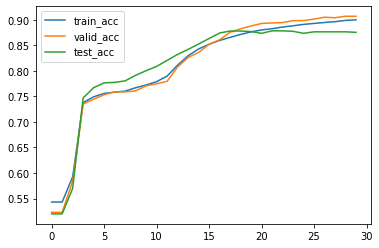

In [76]:
acc_df.plot()

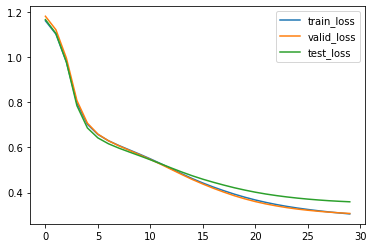

In [77]:
loss_df.plot()